In [1]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# auto reload
%load_ext autoreload
%autoreload 2

In [2]:
paper_figure_folder_path = r"output/paper_figures"

# 1. Attention Maps for Selected RFHs and Sample Cases

In [3]:
from const import D_MODEL_ALIAS_PATH, D_MODEL_SAMPLE_RFH_LOWER_LAYER, D_MODEL_SAMPLE_RFH_MIDDLE_LAYER, D_MODEL_SAMPLE_CASES, D_MODEL_SAMPLE_CASES_ALIAS

input_data_dir = r"output/attention_analysis/selected_traces"

In [4]:
dataset_name, is_withR, layer_of_RFHs = 'MATH500', True, "middle"
# dataset_name, is_withR, layer_of_RFHs = 'MATH500', True, "low"

In [5]:
# Use the data file that has the comparision results between 'withR' and 'withoutR'.
# Namely, the `model_pair_tmp` column has three values: 1 ('withR' win over 'withoutR'), 0 ('withR' and 'withoutR' are equal), -1 ('withoutR' win over 'withR').
df_sel = pd.read_pickle(os.path.join(input_data_dir, f"df_attention_analysis_{dataset_name}_sample_decoding_with_comp.pkl"))

if is_withR:
    df_analysis = df_sel[df_sel['model'].str.contains("withR")]
else:
    df_analysis = df_sel[df_sel['model'].str.contains("withoutR")]

print(df_analysis.shape)
df_analysis.head(2)

(300, 16)


,unique_id,problem,response,model,latency,is_response_finished,answer_pred,extracted_answer,is_answer_extracted,end_think_count,answer,subject,level,is_answer_correct,model_type,model_pair_comp
366,test/precalculus/1199.json,Below is the graph of $y = a \sin (bx + c) + d...,<｜begin▁of▁sentence｜>Below is the graph of $y ...,llama-8B-withR,NaN,1,\n\nTo find the smallest possible value of \( ...,\pi,1,2,\pi,Precalculus,4,1,R1-Llama-8B,1
372,test/algebra/2427.json,"A worker receives an annual wage of $\$20{,}00...",<｜begin▁of▁sentence｜>A worker receives an annu...,llama-8B-withR,NaN,1,"\n\nThe worker deposits $20,000 annually into ...",10,1,2,10,Algebra,5,1,R1-Llama-8B,1


In [6]:
d_model_sample_RFH = D_MODEL_SAMPLE_RFH_MIDDLE_LAYER if layer_of_RFHs == "middle" else D_MODEL_SAMPLE_RFH_LOWER_LAYER
d_top_head_index_by_layer_model = {}

for k, v in d_model_sample_RFH.items():
    d_tmp = {}
    for cord in v:
        if cord[0] not in d_tmp:
            d_tmp[cord[0]] = []
        d_tmp[cord[0]].append(cord[1])
    d_top_head_index_by_layer_model[k] = d_tmp

print(d_top_head_index_by_layer_model)

{'llama-8B': {10: [31]}, 'qwen-7B': {14: [7]}, 'qwen-1p5B': {16: [2]}}


In [7]:
import torch
from transformer_lens import HookedTransformer

from attention_analysis import get_attention_pattern_by_top_head
from attention_analysis import tokenize_parse_text

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_grad_enabled(False)

d_res = {}
for model_alias, l_case_id in D_MODEL_SAMPLE_CASES.items():
    # load model
    model = HookedTransformer.from_pretrained_no_processing(
        model_name=D_MODEL_ALIAS_PATH[model_alias],
        dtype=torch.bfloat16,
        device=device,
    )

    for case_id in tqdm(l_case_id):
        sel_case = df_analysis[(df_analysis['unique_id']==case_id)&(df_analysis['model'].str.contains(model_alias))]
        assert len(sel_case) == 1
        sel_case = sel_case.iloc[0]

        text = sel_case['response']
        tokens, str_tokens, r_start_idx, r_end_idx, tot_answer_tokens = tokenize_parse_text(text, model)
        attn_pattern = get_attention_pattern_by_top_head(tokens, model, d_top_head_index_by_layer_model[model_alias])

        l_wait_token_idx = [i for i, token in enumerate(str_tokens) if 'wait' in token.lower() and i > r_start_idx and i < r_end_idx]
        l_alternative_token_idx = [i for i, token in enumerate(str_tokens) if 'alternative' in token.lower() and i > r_start_idx and i < r_end_idx]
        l_double_check_token_idx = [i for i, token in enumerate(str_tokens) if i > r_start_idx and i < r_end_idx and \
                                     ('check' in token.lower() and 'double' in str_tokens[i-1].lower()) ]

        save_id = f"{model_alias}_{case_id}"
        d_res[save_id] = {}
        d_res[save_id]['r_start_idx'] = r_start_idx
        d_res[save_id]['r_end_idx'] = r_end_idx
        d_res[save_id]['tot_answer_tokens'] = tot_answer_tokens
        d_res[save_id]['tot_tokens'] = len(str_tokens)
        d_res[save_id]['l_wait_token_idx'] = l_wait_token_idx
        d_res[save_id]['l_alternative_token_idx'] = l_alternative_token_idx
        d_res[save_id]['l_double_check_token_idx'] = l_double_check_token_idx
        d_res[save_id]['attn_pattern'] = attn_pattern

/mnt/miniconda3/envs/r2a/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 34.72it/s]


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Llama-8B into HookedTransformer


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 33.02it/s]


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-7B into HookedTransformer


100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B into HookedTransformer


100%|██████████| 3/3 [00:00<00:00,  6.08it/s]


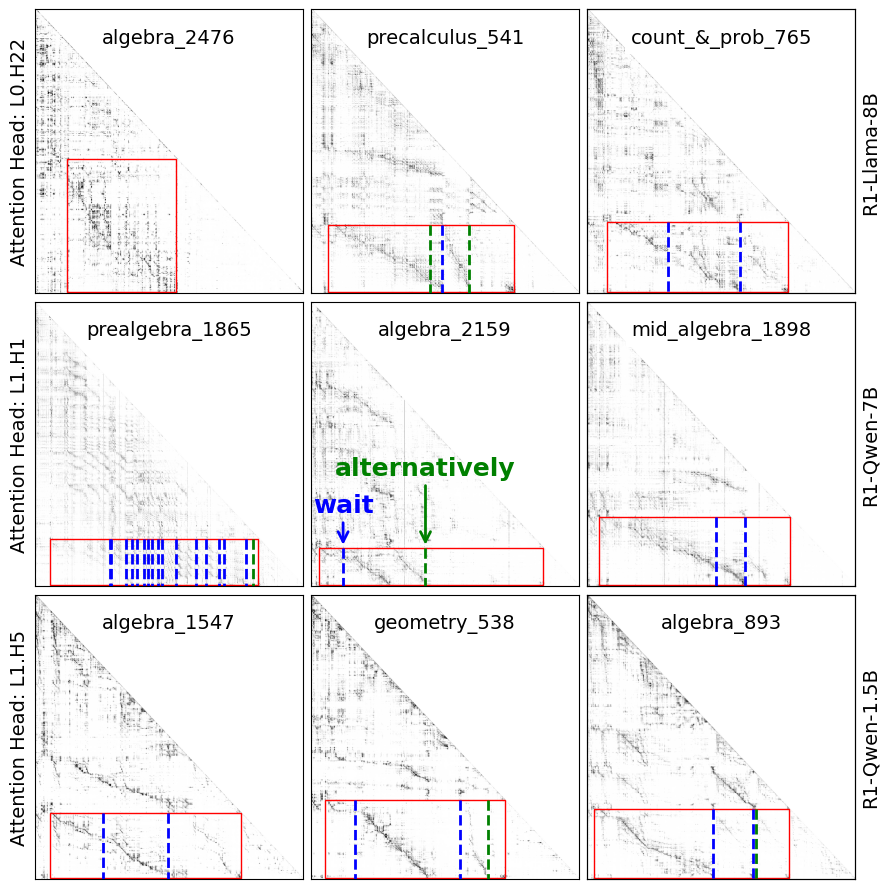

In [8]:
from matplotlib.colors import ListedColormap

d_model_alias_label_mapping = {
    'llama-8B': 'R1-Llama-8B',
    'qwen-7B': 'R1-Qwen-7B',
    'qwen-1p5B': 'R1-Qwen-1.5B'
}

fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for model_alias, l_case_id in D_MODEL_SAMPLE_CASES.items():
    # if model_alias != "qwen-7B":
    #     continue
    row = 0 if model_alias == 'llama-8B' else 1 if model_alias == 'qwen-7B' else 2
    for col, case_id in enumerate(l_case_id):
        save_id = f"{model_alias}_{case_id}"
        sel_case = d_res[save_id]

        r_start_idx = sel_case['r_start_idx']
        r_end_idx = sel_case['r_end_idx']
        tot_answer_tokens = sel_case['tot_answer_tokens']
        tot_tokens = sel_case['tot_tokens']
        l_wait_token_idx = sel_case['l_wait_token_idx']
        l_alternative_token_idx = sel_case['l_alternative_token_idx']
        l_double_check_token_idx = sel_case['l_double_check_token_idx']
        attn_pattern = sel_case['attn_pattern']
        layer, head = d_model_sample_RFH[model_alias][0]
        attn_pattern = attn_pattern[f"{layer}_{head}"]
        
        ax = axes[row, col]
        # ax.set_title(f"{model_alias} {case_id}")
        # ax.set_xlabel("Token Index")
        # ax.set_ylabel("Attention Score")
        
        # Plot the attention pattern
        vmax = np.percentile(attn_pattern, 99)
        # Create a custom colormap from inferno_r but with white at the low end
        original_cmap = plt.cm.inferno_r(np.linspace(0, 1, 256))
        original_cmap[0] = [1, 1, 1, 1]  # Set the lowest color to white (RGBA)
        custom_cmap = ListedColormap(original_cmap)
        # im = ax.imshow(attn_pattern, cmap=custom_cmap, vmin=0, vmax=vmax, aspect='auto')
        im = ax.imshow(attn_pattern, cmap='Greys', vmin=0, vmax=vmax, aspect='auto')
        # im = ax.imshow(attn_pattern, cmap='viridis', vmin=0, vmax=vmax, aspect='auto')
        # im = ax.imshow(attn_pattern, cmap='inferno_r', vmin=0, vmax=vmax, aspect='auto')

        # Draw rectangle around the reasoning area
        # ax.axvline(r_start_idx, color='red', linestyle='--', alpha= 0.3)
        # ax.axvline(r_end_idx, color='red', linestyle='--', alpha= 0.3)
        # ax.axhline(r_start_idx, color='red', linestyle='--', alpha= 0.3)
        # ax.axhline(r_end_idx, color='red', linestyle='--', alpha= 0.3)
        rect = plt.Rectangle((r_start_idx, r_end_idx), r_end_idx-r_start_idx, tot_tokens * 0.995 - r_end_idx , 
                     fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

        case_id_alias = D_MODEL_SAMPLE_CASES_ALIAS[model_alias][col]
        case_id_trim = '_'.join(case_id_alias.split('.')[0].split('/')[-2:])
        ax.text(tot_tokens/2, tot_tokens * 0.1, case_id_trim , fontsize=14, ha='center', va='center', color='black', backgroundcolor='white')

        # Highlight the wait tokens
        for idx in l_wait_token_idx:
            ax.plot([idx, idx], [r_end_idx, attn_pattern.shape[0]*0.999], 'b--', alpha=1, lw=2)
        # Highlight the alternative tokens
        for idx in l_alternative_token_idx:
            ax.plot([idx, idx], [r_end_idx, attn_pattern.shape[0]*0.999], 'g--', alpha=1, lw=2)
        # # Highlight the double check tokens
        # for idx in l_double_check_token_idx:
        #     ax.plot([idx, idx], [r_end_idx, attn_pattern.shape[0]*0.999], '--', color='purple', alpha=1, lw=2)

        # disable the shown of axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # ax ylabel
        axes[0][0].set_ylabel("Attention Head: L0.H22", fontsize=14)
        axes[1][0].set_ylabel("Attention Head: L1.H1", fontsize=14)
        axes[2][0].set_ylabel("Attention Head: L1.H5", fontsize=14)
        
        if col == 2:
            ax2 = ax.twinx()
            ax2.set_ylabel(d_model_alias_label_mapping[model_alias], fontsize=14)
            ax2.set_yticks([])  # Hide the ticks of the secondary y-axis

        if row == 1 and col == 1:
            # Add "wait" text
            ax.annotate('wait', 
                        xy=(l_wait_token_idx[0], r_end_idx), 
                        xytext=(l_wait_token_idx[0], r_end_idx - 180),
                        fontsize=18, color='blue',
                        ha='center', va='bottom', 
                        # backgroundcolor='white',
                        fontweight='bold',
                        arrowprops=dict(arrowstyle='->', color='blue', lw=2))

            # Add "alternatively" text
            ax.annotate('alternatively', 
                        xy=(l_alternative_token_idx[0], r_end_idx), 
                        xytext=(l_alternative_token_idx[0], r_end_idx - 400),
                        fontsize=18, color='green',
                        ha='center', va='bottom', 
                        fontweight='bold',
                        # backgroundcolor='white',
                        arrowprops=dict(arrowstyle='->', color='green', lw=2))

plt.tight_layout()
plt.subplots_adjust(hspace=0.03, wspace=0.03)

# save_fg_path = os.path.join(paper_figure_folder_path, f'attn_pattern_case_study_{layer_of_RFHs}_layer_{dataset_name}_withR_grey.png')
# if not os.path.exists(os.path.dirname(save_fg_path)):
#     os.makedirs(os.path.dirname(save_fg_path))
# plt.savefig(save_fg_path, dpi=300, bbox_inches='tight')
# # save as pdf
# save_fg_path_pdf = os.path.join(paper_figure_folder_path, f'attn_pattern_case_study_{layer_of_RFHs}_layer_{dataset_name}_withR_grey.pdf')
# plt.savefig(save_fg_path_pdf, dpi=300, bbox_inches='tight')

plt.show()

# 2. Application of RFHs: Understand Why Reasoning Fails

In [9]:
input_data_dir = r"output/attention_analysis/selected_traces"

dataset_name, is_withR = 'MATH500', True
model_alias = 'qwen-1p5B'

In [10]:
import torch
from transformer_lens import HookedTransformer
from const import D_MODEL_ALIAS_PATH

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_grad_enabled(False)

model = HookedTransformer.from_pretrained_no_processing(
    model_name=D_MODEL_ALIAS_PATH[model_alias],
    dtype=torch.bfloat16,
    device=device,
)

Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B into HookedTransformer


In [11]:
# Use the data file that has the comparision results between 'withR' and 'withoutR'.
# Namely, the `model_pair_tmp` column has three values: 1 ('withR' win over 'withoutR'), 0 ('withR' and 'withoutR' are equal), -1 ('withoutR' win over 'withR').
df_sel = pd.read_pickle(os.path.join(input_data_dir, f"df_attention_analysis_{dataset_name}_sample_decoding_with_comp.pkl"))

if is_withR:
    df_analysis = df_sel[df_sel['model'].str.contains("withR")]
else:
    df_analysis = df_sel[df_sel['model'].str.contains("withoutR")]
    
df_analysis = df_analysis[df_analysis['model'].str.contains(model_alias)]

print(df_analysis.shape)
df_analysis.head(2)

(100, 16)


,unique_id,problem,response,model,latency,is_response_finished,answer_pred,extracted_answer,is_answer_extracted,end_think_count,answer,subject,level,is_answer_correct,model_type,model_pair_comp
2030,test/number_theory/515.json,What is the smallest positive perfect cube tha...,<｜begin▁of▁sentence｜>What is the smallest posi...,qwen-1p5B-withR,NaN,1,\n\nTo find the smallest positive perfect cube...,27,1,2,27,Number Theory,3,1,R1-Qwen-1.5B,1
2031,test/precalculus/927.json,"The set of points $(x,y,z)$ that satisfy\n\[2x...","<｜begin▁of▁sentence｜>The set of points $(x,y,z...",qwen-1p5B-withR,NaN,1,\n\nTo find the angle between the two lines de...,90,1,2,90^\circ,Precalculus,4,1,R1-Qwen-1.5B,1


In [12]:
from const import D_TOP_RFHS_BY_LAYER_HEAD

d_top_head_index_by_layer_model = {}

for k, v in D_TOP_RFHS_BY_LAYER_HEAD.items():
    d_tmp = {}
    for cord in v:
        if cord[0] not in d_tmp:
            d_tmp[cord[0]] = []
        d_tmp[cord[0]].append(cord[1])
    d_top_head_index_by_layer_model[k] = d_tmp

print(d_top_head_index_by_layer_model)

{'llama-8B': {8: [11, 9, 1], 10: [31], 0: [22], 13: [6, 18, 5, 4], 16: [1]}, 'qwen-7B': {16: [0, 14], 19: [15], 14: [7, 0], 1: [1], 17: [18, 19, 14], 22: [7]}, 'qwen-1p5B': {16: [2, 11, 0], 1: [5], 19: [1, 5], 12: [1], 23: [2], 14: [3], 20: [9]}}


In [13]:
from attention_analysis import get_attention_pattern_by_top_head, get_raw_attention_patterns
from attention_analysis import tokenize_parse_text
from const import D_MODEL_SAMPLE_CASES_FOR_COLORED_TOKENS

sample_case = df_analysis[df_analysis['unique_id']==D_MODEL_SAMPLE_CASES_FOR_COLORED_TOKENS[model_alias][0]]
assert len(sample_case) == 1

sample_case = sample_case.iloc[0]

unique_id = sample_case['unique_id']
print('unique_id:', unique_id)

text = sample_case['response']
tokens, str_tokens, r_start_idx, r_end_idx, tot_answer_tokens = tokenize_parse_text(text, model)
print(r_start_idx, r_end_idx, tot_answer_tokens)

d_top_head_index_by_layer = d_top_head_index_by_layer_model[model_alias]
print(d_top_head_index_by_layer)

ret = get_attention_pattern_by_top_head(tokens, model, d_top_head_index_by_layer)

attn_raw = get_raw_attention_patterns(
        text=text,
        model=model
    )

unique_id: test/algebra/1547.json
76 989 297
{16: [2, 11, 0], 1: [5], 19: [1, 5], 12: [1], 23: [2], 14: [3], 20: [9]}


In [14]:
print(sample_case['unique_id'])
print(sample_case['response'])

test/algebra/1547.json
<｜begin▁of▁sentence｜>Simplify $4(3r^3+5r-6)-6(2r^3-r^2+4r)$, and express your answer in the form $Ar^2 + Br + C$, where $A$, $B$, and $C$ are integers. Please reason step by step, and put your final answer within \boxed{}. <think>
Okay, so I need to simplify this expression: 4(3r^3 + 5r - 6) - 6(2r^3 - r^2 + 4r). Hmm, let me see. I remember from algebra that when you have parentheses like this, you need to distribute the multiplication across each term inside the parentheses. So, I think I should start by expanding both parts separately and then combine like terms.

First, let me handle the 4 multiplied by each term inside the first parentheses. So, 4 times 3r^3 is... 12r^3. Then, 4 times 5r is 20r. And 4 times -6 is -24. Okay, so that part simplifies to 12r^3 + 20r - 24. Got that.

Now, moving on to the second part: -6 multiplied by each term inside the second parentheses. Hmm, that might be a bit trickier because of the negative sign. Let's take it step by step

In [15]:
# find out the start and end index of the \boxed{} answer

focus_offset = r_end_idx - 20
focus_str_tokens = str_tokens[focus_offset:r_end_idx]
print(focus_str_tokens)

left_brace_tokens, right_brace_tokens = [], []
left_brace_idx, right_brace_idx = -1, -1

for i, token in enumerate(focus_str_tokens):
    if '{' in token:
        left_brace_tokens.append(token)
        left_brace_idx = i
    if '}' in token:
        right_brace_tokens.append(token)
        right_brace_idx = i

assert len(left_brace_tokens) == 1 and len(right_brace_tokens) == 1, "There should be exactly one '{' and one '}' in the focus string tokens."
boxed_answer_start_idx = focus_offset + left_brace_idx + 1
boxed_answer_end_idx = focus_offset + right_brace_idx

print(str_tokens[boxed_answer_start_idx:boxed_answer_end_idx])

['**', 'Final', ' Answer', '**\n', 'The', ' simplified', ' expression', ' is', ' \\', 'boxed', '{', '6', 'r', '^', '2', ' -', ' ', '4', 'r', '}.\n']
['6', 'r', '^', '2', ' -', ' ', '4', 'r']


In [16]:
# The following hard coded indices only work for the reasoning trace of "test/algebra/1547.json" collected using 'Qwen-1.5B'.

# Top Reasoning-Focus Heads
attn = ret["16_2"] 

# # Average over top 10 RFHs
# attn_combine = []
# for k, v in ret.items():
#     attn_combine.append(v)
# attn_combine = np.array(attn_combine)
# attn = attn_combine.mean(axis=0)

# # average over all heads and layers
# attn_combine = []
# for k, v in attn_raw.items():
#     attn_combine.append(v[0])
# attn_combine = np.array(attn_combine)
# attn = attn_combine.mean(axis=0).mean(axis=0) 

boxed_answer_attn = attn[boxed_answer_start_idx:boxed_answer_end_idx, r_start_idx:r_end_idx].mean(axis=0)
answer_0_attn = attn[634:641, r_start_idx:r_end_idx].mean(axis=0)
answer_1_attn = attn[715:725, r_start_idx:r_end_idx].mean(axis=0)
answer_2_attn = attn[932:939, r_start_idx:r_end_idx].mean(axis=0)
vanish_linear_term_attn = attn[703:707, r_start_idx:r_end_idx].mean(axis=0)
vanish_linear_term_fine_grain_attn_1 = attn[703:704, r_start_idx:r_end_idx].mean(axis=0)
vanish_linear_term_fine_grain_attn_2 = attn[704:705, r_start_idx:r_end_idx].mean(axis=0)
vanish_linear_term_fine_grain_attn_3 = attn[705:706, r_start_idx:r_end_idx].mean(axis=0)
vanish_linear_term_fine_grain_attn_4 = attn[706:707, r_start_idx:r_end_idx].mean(axis=0)

In [17]:
l_idx_token = [f"{i}_{token}" for i, token in enumerate(str_tokens[:r_end_idx])]
print(l_idx_token)

['0_<｜begin▁of▁sentence｜>', '1_S', '2_implify', '3_ $', '4_4', '5_(', '6_3', '7_r', '8_^', '9_3', '10_+', '11_5', '12_r', '13_-', '14_6', '15_)-', '16_6', '17_(', '18_2', '19_r', '20_^', '21_3', '22_-r', '23_^', '24_2', '25_+', '26_4', '27_r', '28_)$', '29_,', '30_ and', '31_ express', '32_ your', '33_ answer', '34_ in', '35_ the', '36_ form', '37_ $', '38_Ar', '39_^', '40_2', '41_ +', '42_ Br', '43_ +', '44_ C', '45_$,', '46_ where', '47_ $', '48_A', '49_$,', '50_ $', '51_B', '52_$,', '53_ and', '54_ $', '55_C', '56_$', '57_ are', '58_ integers', '59_.', '60_ Please', '61_ reason', '62_ step', '63_ by', '64_ step', '65_,', '66_ and', '67_ put', '68_ your', '69_ final', '70_ answer', '71_ within', '72_ \\', '73_boxed', '74_{}.', '75_ ', '76_<think>', '77_\n', '78_Okay', '79_,', '80_ so', '81_ I', '82_ need', '83_ to', '84_ simplify', '85_ this', '86_ expression', '87_:', '88_ ', '89_4', '90_(', '91_3', '92_r', '93_^', '94_3', '95_ +', '96_ ', '97_5', '98_r', '99_ -', '100_ ', '101_6', 

In [18]:
# no to show self attn part
vanish_linear_term_attn_no_selfattn = vanish_linear_term_attn.copy()
vanish_linear_term_attn_no_selfattn[703-r_start_idx:707-r_start_idx] = 0  # set

In [20]:
import circuitsvis as cv

# display_attn = boxed_answer_attn
# display_attn = answer_0_attn
# display_attn = answer_1_attn
# display_attn = answer_2_attn
# display_attn = vanish_linear_term_attn
display_attn = vanish_linear_term_attn_no_selfattn
# display_attn = vanish_linear_term_fine_grain_attn_1
# display_attn = vanish_linear_term_fine_grain_attn_2
# display_attn = vanish_linear_term_fine_grain_attn_3
# display_attn = vanish_linear_term_fine_grain_attn_4

cv.tokens.colored_tokens(str_tokens[r_start_idx:r_end_idx], display_attn)